In [1]:
import math
import tensorflow as tf
from tensorflow.contrib import learn
import numpy as np
import pylab as plt
import pickle
import os
import csv
import sys
import time
from datetime import timedelta
import pandas

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
LEARNING_RATE = 0.01
EPOCHS = 2000
BATCH_SIZE = 128
MAX_DOC_LEN = 100
CHAR_DEPTH = 256
WORD_WIDTH = 20
NUM_CLASSES = 15
DROP = True
EMBEDDING_SIZE = 50
NUM_HIDDEN = 20

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [14]:
DATA_DIR = "..\data"
SAVE_DIR = "..\data\PartB_Result"
RESULT_DIR = "..\data\PartB_Result\Q3\1110"
TRAIN_CHAR_FILENAME = "Train_char.out"
TEST_CHAR_FILENAME = "Test_char.out"
TRAIN_WORD_FILENAME = "Train_word_raw.out"
TEST_WORD_FILENAME = "Test_word_raw.out"

In [4]:
with open(os.path.join(SAVE_DIR, TRAIN_CHAR_FILENAME),"rb") as f:
    trainX, tmp_trainY = pickle.load(f)

In [5]:
with open(os.path.join(SAVE_DIR, TEST_CHAR_FILENAME),"rb") as f:
    testX, tmp_testY = pickle.load(f)

In [6]:
trainY_targets = np.array(tmp_trainY).reshape(-1)
trainY = np.eye(NUM_CLASSES)[trainY_targets]

testY_targets = np.array(tmp_testY).reshape(-1)
testY = np.eye(NUM_CLASSES)[testY_targets]
# trainY = y_train
# testY = y_test

In [7]:
def rnn_model(x, n_words):

    word_vectors = tf.contrib.layers.embed_sequence(
        x, vocab_size=n_words, embed_dim=EMBEDDING_SIZE)

    word_list = tf.unstack(word_vectors, axis=1)

    cell = tf.nn.rnn_cell.GRUCell(NUM_HIDDEN)
    _, encoding = tf.nn.static_rnn(cell, word_list, dtype=tf.float32)

    logits = tf.layers.dense(encoding, NUM_CLASSES, activation=None)

    return logits, word_list

In [9]:
n_chars = max([max(tmp) for tmp in trainX]+[max(tmp) for tmp in testX])

In [10]:
n_chars

195

In [11]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [12]:
x = tf.placeholder(tf.int64, [None, MAX_DOC_LEN])
d = tf.placeholder(tf.float32, [None, NUM_CLASSES])
y, word_list = rnn_model(x, n_chars)

cross_entropy = setup_cross_entropy(labels=d, logits=y)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(loss)

In [13]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

In [15]:
saver = tf.train.Saver()
if not os.path.exists(RESULT_DIR):
    print("Not Exist")
    os.makedirs(RESULT_DIR)

Not Exist


In [16]:
def plot_graph(EPOCHS, BATCH_SIZE, acc_record, fileName, isTrain, error = False):
    if error:  
        acc_record = [1-tmp for tmp in acc_record]
        if isTrain:
            yLabel = 'Train error'
        else:
            yLabel = 'Test error'
    else:
        if isTrain:
            yLabel = 'Train accuracy'
        else:
            yLabel = 'Test accuracy'
    plt.figure(1)
    plt.plot(range(EPOCHS), acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel(yLabel)
    plt.savefig(os.path.join(RESULT_DIR, fileName))
    plt.show()

In [17]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

In [18]:
train_acc_backup = []
test_acc_backup = []
time_usage_backup = []
total_time_backup = []

iter 0: Train accuracy 0.0944643 Test accuracy:  0.09 *
Time usage: 0:00:06
iter 100: Train accuracy 0.523393 Test accuracy:  0.4485714 *
Time usage: 0:00:25
iter 200: Train accuracy 0.720536 Test accuracy:  0.5742857 *
Time usage: 0:00:45
iter 300: Train accuracy 0.854464 Test accuracy:  0.5928571 *
Time usage: 0:01:05
iter 400: Train accuracy 0.892321 Test accuracy:  0.6242857 *
Time usage: 0:01:26
iter 500: Train accuracy 0.87125 Test accuracy:  0.6314286 *
Time usage: 0:01:46
iter 600: Train accuracy 0.93625 Test accuracy:  0.62 
Time usage: 0:02:05
iter 700: Train accuracy 0.9675 Test accuracy:  0.62 
Time usage: 0:02:25
iter 800: Train accuracy 0.975357 Test accuracy:  0.61 
Time usage: 0:02:44
iter 900: Train accuracy 0.986429 Test accuracy:  0.61142856 
Time usage: 0:03:04
iter 1000: Train accuracy 0.984107 Test accuracy:  0.6242857 
Time usage: 0:03:24
iter 1100: Train accuracy 0.9275 Test accuracy:  0.62714285 
Time usage: 0:03:43
iter 1200: Train accuracy 0.992321 Test accur

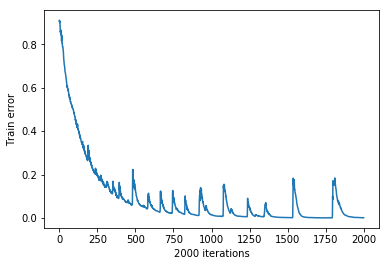

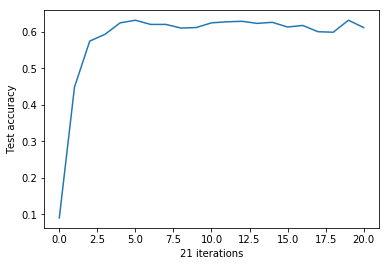

In [23]:
# print("BATCH_SIZE=", BATCH_SIZE)
total_iterations = 0
train_acc = []
start_time = time.time()
train_acc_record = []
test_acc_record = []
epoch_time_record = []

best_test_acc = 0.0
last_improvement = 0
improved_str = ""
test_count = 0
train_count = 0
mul = int(len(trainX)/BATCH_SIZE)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(EPOCHS):
        epoch_start_time = time.time()
        
#         for j in range(len(x_allBatch)):
#         for j in range(mul):
#             feed_dict_train = {x: x_allBatch[j], d: y_allBatch[j]}
#             x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)
        feed_dict_train = {x: trainX, d: trainY}
        sess.run(train_op, feed_dict=feed_dict_train)
        train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))
        train_count += 1
            
        epoch_end_time = time.time()
        epoch_time_diff = epoch_end_time-epoch_start_time
        epoch_time_record.append(epoch_time_diff)

        if (i % 100 == 0) or (i == (EPOCHS - 1)):
            test_count += 1
            test_accuracy = sess.run(accuracy, feed_dict={x: testX, d: testY})
            test_acc_record.append(test_accuracy)
            if DROP:
                if test_accuracy > best_test_acc:
                    best_test_acc = test_accuracy
                    last_improvement = i
                    saver.save(sess=sess, save_path=RESULT_DIR)
                    improved_str = "*"
                else:
                    improved_str = ''
            else:
                saver.save(sess=sess, save_path=RESULT_DIR)

            print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)
            print("Time usage: " + str(timedelta(seconds=int(round(time.time()-start_time)))))


# Ending time.
end_time = time.time()

# Difference between start and end-times.
time_dif = end_time - start_time

# Print the time-usage.
print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

train_graphName = "PartB-Q3-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
test_graphName = "PartB-Q3-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png"
plot_graph(train_count, BATCH_SIZE, train_acc_record,train_graphName, isTrain = True, error=True)
plot_graph(test_count, BATCH_SIZE, test_acc_record, test_graphName, isTrain = False)


train_acc_backup.append(train_acc_record)
test_acc_backup.append(test_acc_record)
time_usage_backup.append(epoch_time_record)
total_time_backup.append(time_dif)

#=========== Save all the data for EACH TRAINING Has Done ============#
fileNameTail = str(EPOCHS)+'-'+str(BATCH_SIZE)+".out"

train_acc_filename = "PartB-Q3-Train_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, train_acc_filename), 'wb') as fp:
    pickle.dump(train_acc_backup, fp)

test_acc_filename = "PartB-Q3-Test_Acc-"+fileNameTail
with open(os.path.join(RESULT_DIR, train_acc_filename), 'wb') as fp:
    pickle.dump(test_acc_backup, fp)

time_usage_filename = "PartB-Q3-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)

time_usage_filename = "PartB-Q3-Time_Usage-"+fileNameTail
with open(os.path.join(RESULT_DIR, time_usage_filename), 'wb') as fp:
    pickle.dump(time_usage_backup, fp)        


In [ ]:
# x_allBatch[0].shape

In [ ]:
def generate_batch(X_in, y_in, batch_size):
    X = list(X_in)
    y = list(y_in)
    
    if len(X)!=len(y):
        print("Error: len(X)!=len(Y)")
        return None
    batched_X = []
    batched_y = []
    count = 0
    while (len(X) >= batch_size):
        batched_X.append(X[0:batch_size])
        del X[0:batch_size]
        batched_y.append(y[0:batch_size])
        del y[0:batch_size]
        if count % 10 == 0:
            print (count)
        count += 1
    
    if len(X) != 0:
        remain = batch_size-len(X)
        X.extend(batched_X[0][0:remain])
        y.extend(batched_y[0][0:remain])
        batched_X.append(X)
        batched_y.append(y)
        print(count, "Remain rescaled to", len(X))
    
    return (batched_X, batched_y)

In [ ]:
x_allBatch, y_allBatch = generate_batch(trainX, trainY, BATCH_SIZE)

In [ ]:
x_allBatch = np.array(x_allBatch)
y_allBatch = np.array(y_allBatch)

print(x_allBatch.shape)
print(y_allBatch.shape)

In [ ]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def data_read_words():
  
    x_train, y_train, x_test, y_test = [], [], [], []

    with open(os.path.join(DATA_DIR, 'train_medium.csv'), encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_train.append(row[2])
            y_train.append(int(row[0]))

    with open(os.path.join(DATA_DIR, "test_medium.csv"), encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            x_test.append(row[2])
            y_test.append(int(row[0]))

    x_train = pandas.Series(x_train)
    y_train = pandas.Series(y_train)
    x_test = pandas.Series(x_test)
    y_test = pandas.Series(y_test)
    y_train = y_train.values
    y_test = y_test.values

    vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
        MAX_DOC_LEN)

    x_transform_train = vocab_processor.fit_transform(x_train)
    x_transform_test = vocab_processor.transform(x_test)

    x_train = np.array(list(x_transform_train))
    x_test = np.array(list(x_transform_test))

    no_words = len(vocab_processor.vocabulary_)
    print('Total words: %d' % no_words)

    return x_train, y_train, x_test, y_test, no_words

In [8]:
x_train, y_train, x_test, y_test, n_words = data_read_words()

NameError: name 'data_read_words' is not defined